##Práctico 6: predicción por medio de aprendizaje profundo

El día de hoy vamos a predecir anomalías cardíacas mediante mediciones de electrocardiogramas tomados con 12 canales y redes convolucionales o CNN

El electrocardiograma, abreviado como ECG o EKG, es una prueba no invasiva que registra la actividad eléctrica del corazón a lo largo del tiempo. Se realiza colocando electrodos en la piel del paciente, generalmente en el pecho, brazos y piernas. Estos electrodos capturan las señales eléctricas generadas por la actividad del corazón y las amplifican para producir un gráfico visual que muestra las ondas y complejos característicos del ciclo cardíaco.

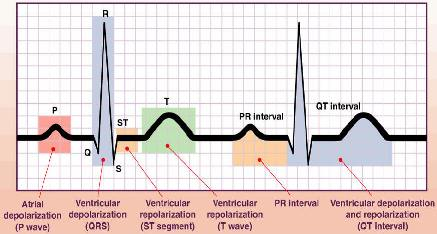

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Artículo: A large scale 12-lead electrocardiogram database for arrhythmia study

Este nuevo archivo de investigación para señales de electrocardiograma (ECG) de 12 derivaciones fue creado en colaboración con la Universidad Chapman, el Hospital de Personas de Shaoxing y el Primer Hospital de Ningbo. Su objetivo es permitir a la comunidad científica realizar estudios sobre arritmias y otras condiciones cardiovasculares. La fibrilación auricular y otras arritmias afectan la salud pública y la calidad de vida. El ECG, como prueba no invasiva, es vital para detectar estas condiciones. Recopilaron una base de datos de ECG con 12 derivaciones de 45,152 pacientes, etiquetados por expertos, para facilitar el diseño y comparación de técnicas estadísticas y de aprendizaje automático en estudios sobre estas condiciones. [Base de datos](https://physionet.org/content/ecg-arrhythmia/1.0.0/)




In [ ]:
ruta_datos = '/content/drive/MyDrive/Curso/Práctico 6/'

In [ ]:
metadata = pd.read_excel(ruta_datos + 'data/samples.xlsx')

In [ ]:
metadata['Rhythm'].unique() #Los tipos de arritmias que tenemos en el df

array(['AFIB', 'AF', 'SB', 'ST', 'SR', 'SA', 'SVT', 'AT', 'SAAWR',
       'AVNRT', 'AVRT'], dtype=object)

Ahora vamos a hacer el vector de clases por medio de los metadatos.
La columna 'Rhythm' del df 'metadata' creado anteriormente con el excel 'samples.xlsx' contiene el diagnóstico dado a cada paciente.

Tenemos múltiples posibles arritmias. Para seleccionar un número pequeño de clases, vamos a elegir un número mínimo de elementos que pertenecen a una clase para que sea una clase válida.

Luego vamos a importar sólo los ECG de los pacientes que estén asociados a una clase


In [ ]:
import re

def get_clases(N_min = 300):
  def limpiar_elemento(elemento):
    # Usar expresiones regulares para mantener solo caracteres alfanuméricos
    return re.sub(r'\W+', '', elemento)

  clases = pd.DataFrame(list(metadata['Rhythm']), index = metadata['FileName'], columns=['Rhythm'])
  clases.sort_index(inplace = True)

  clases['Rhythm'] = clases['Rhythm'].str.split()
  clases['Rhythm'] = clases['Rhythm'].apply(lambda lista: [limpiar_elemento(elemento) for elemento in lista])
  clases_exploded = clases.explode('Rhythm')

  conteo_elementos = clases_exploded['Rhythm'].value_counts()
  claves_filtradas = conteo_elementos[conteo_elementos > N_min].index
  dict_c2b = dict(enumerate(claves_filtradas))
  dict_b2c = dict((clave, valor) for valor, clave in enumerate(claves_filtradas))

  return clases, dict_b2c, dict_c2b


In [ ]:
#Pasamos a clases numéricas

def b2c(valor):
  inter = list(set(dict_b2c.keys()).intersection(set(valor))) #Sólo diagnosticos que tengan N_min cantidad de ejemplos
  if len(inter) == 1:  #Pacientes con un solo diagnóstico
    i = inter[0]
    return dict_b2c[i]


clases, dict_b2c, dict_c2b = get_clases(N_min=400)

clases['Class'] = clases['Rhythm'].apply(b2c)
clases.dropna(inplace = True)

aux = [print(f"Diagnóstico {dict_c2b[c]} clase {c}") for c in clases["Class"].unique()]


Diagnóstico ST clase 1.0
Diagnóstico AFIB clase 0.0


In [ ]:
pacientes = {}
for paciente in clases.index:
  try:
    pacientes[paciente] = pd.read_csv(ruta_datos +"data/" + paciente + '.csv', header = None)
  except:
    pass


In [ ]:
pacientes[clases.index[0]] #Al ser un diccionario no pueden acceder directamente con el indice

,0,1,2,3,4,5,6,7,8,9,10,11
0,-165.33,-358.970,-121.710,270.250,-28.869,-231.16,448.39,636.52,618.45,-7.8987,-315.160,-570.84
1,-150.75,-336.810,-114.980,251.410,-23.883,-217.52,441.74,646.47,642.56,35.3890,-269.510,-532.21
2,-136.69,-315.560,-108.630,233.450,-19.126,-204.36,436.06,656.31,665.95,76.5720,-225.830,-495.39
3,-123.74,-296.230,-103.090,217.230,-14.815,-192.29,432.27,666.14,688.05,113.5100,-186.000,-461.84
4,-112.57,-279.750,-98.611,203.530,-11.213,-181.87,431.08,676.31,708.47,144.3000,-151.680,-432.56
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-190.32,52.396,170.760,74.543,-170.890,107.63,310.73,398.59,538.11,230.9700,87.684,-249.88
4996,-178.98,65.438,171.870,62.325,-165.650,114.41,302.32,398.80,541.18,245.2700,110.940,-226.42
4997,-171.04,74.181,172.080,53.876,-161.490,118.93,297.25,401.02,544.16,254.4800,129.340,-207.20
4998,-165.46,79.570,171.300,48.203,-157.840,121.64,293.97,403.86,546.18,259.5100,144.140,-190.64


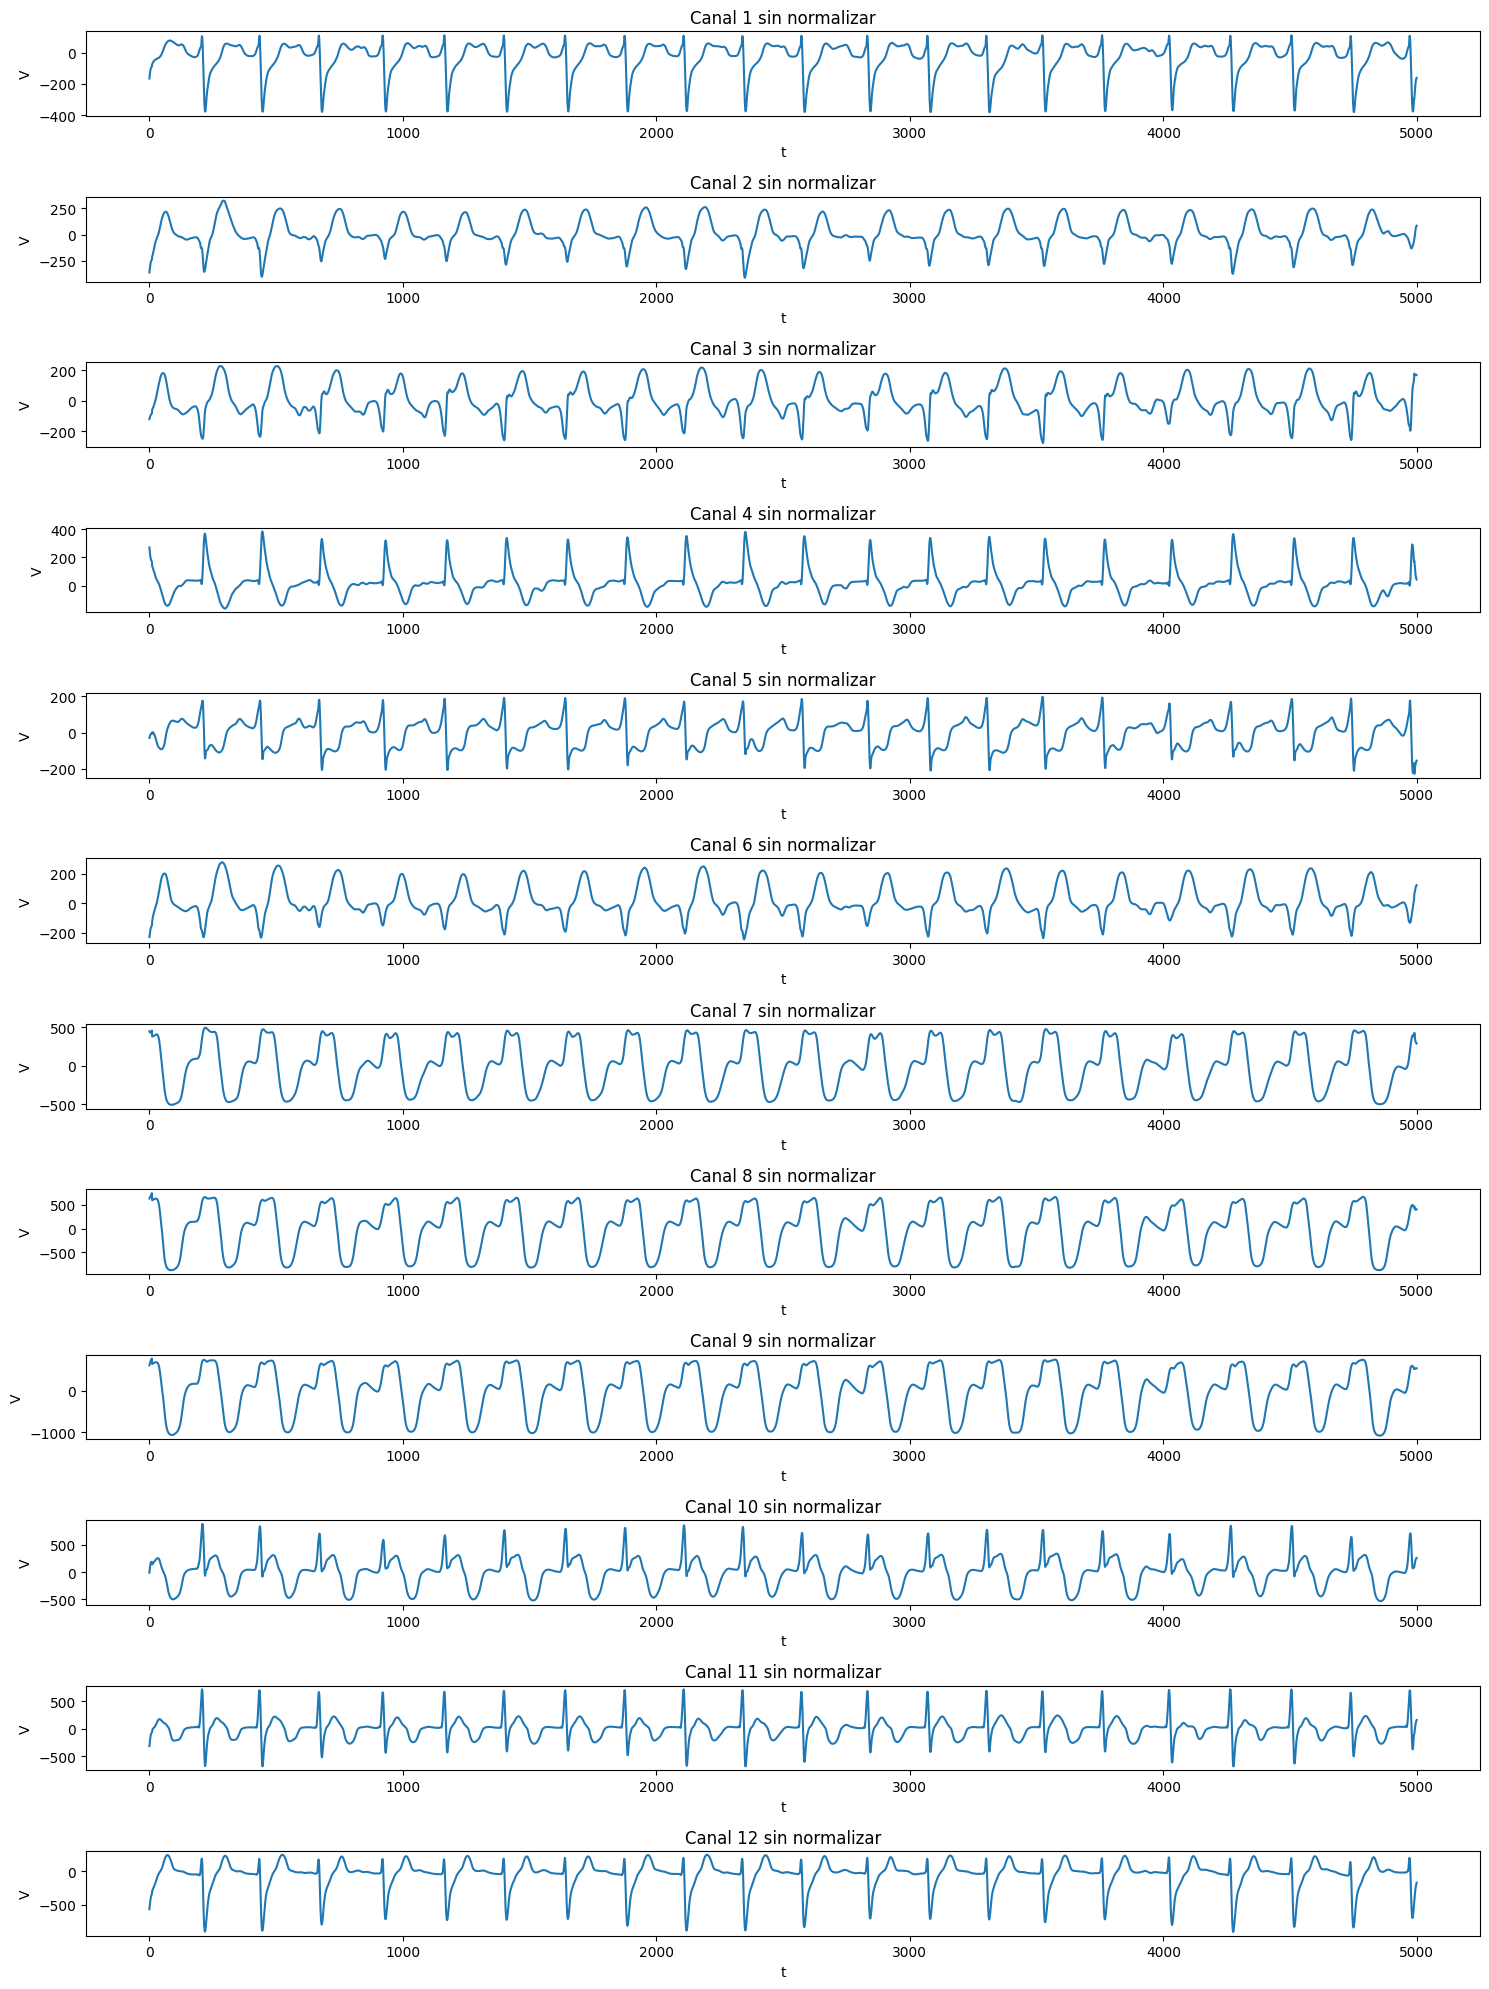

Rhythm    [ST]
Class      1.0
Name: MUSE_20180111_155115_19000, dtype: object


In [ ]:
fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(15, 20))  # Ajusta el tamaño según sea necesario
ind = 0
x1=np.array(pacientes[clases.index[ind]].T)
# Iterar sobre cada subgráfico y trazar los datos
for i in range(12):
    axs[i].plot(x1[i])
    axs[i].set_title(f'Canal {i+1} sin normalizar')
    axs[i].set_xlabel('t')
    axs[i].set_ylabel('V')

# Ajustar el diseño de los subgráficos para evitar solapamiento
plt.tight_layout()
# Mostrar el gráfico
plt.show()
print(clases.iloc[ind])

El diccionario 'pacientes' tiene como clave el valor de cada individuo, y cada valor asociado a esa clave es un dataframe con los ECG de los pacientes seleccionados de acuerdo al tipo de arritmia que presentaban. Cada df tiene 10s de medición a 500Hz de 12 canales (5000 filas x 12 columnas)

El bucle for contiene las líneas try, except. Son utilizadas normalmente cuando nuestro código puede dar algún error y queremos controlarlo. Es la forma más sencilla de hacer un manejo de excepciones.


### Librería de aprendizaje profundo TensorFlow

Librería de Google, tiene bastantes cosas interesantes como modelos pre-entrenados, bases de datos y permite la portabilidad de los modelos a microcontroladores y dispositivos moviles.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

N_class = len(clases['Class'].unique())
# X son las características, y es la variable objetivo
X = pd.DataFrame(index=sorted(pacientes.keys()))  # DataFrame con los índices, para acceder al diccionario antes creado y poder usar la función de sklearn
clases['Class'].sort_index(inplace=True)

y = to_categorical(clases['Class'], N_class)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
y #salida en one-hot-encoder

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)


El artículo original tiene que la salida de la capa densa es 1, lo que quiere decir predice con clases directamente (osea si es 0, 1 o 2)

Pero nosotros pasamos las clases a formato one-hot-encoder. Eso nos permite acotar la salida de [0, 1] sin importar la cantidad de clases a trabajar (por medio de la función de activación *softmax*).

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.metrics import Precision, Recall

def get_model():
  model = models.Sequential()

  model.add(layers.Conv1D(15, kernel_size=54, input_shape=(5000, 12)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=2))

  model.add(layers.Conv1D(12, kernel_size=26))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=2))

  model.add(layers.Conv1D(12, kernel_size=35))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=3))

  model.add(layers.Conv1D(23, kernel_size=43))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=4))

  model.add(layers.Conv1D(35, kernel_size=4))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=4))

  # Aplanar la salida para las capas densas
  model.add(layers.Flatten())

  model.add(layers.Dense(10))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.3))

  # Capa de salida
  model.add(layers.Dense(N_class, activation='softmax'))

  # Los parámetros pueden ser ingresados al modelo de esta forma o como un argumento normal de una función, es decir, argumento = "parámetro"
  learning_rate = 0.001
  optimizer = Adadelta(learning_rate=learning_rate)

  #incluso se podrían incluir funciones propias (no lo veremos hoy)

  # Compilar el modelo con el optimizador personalizado
  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'categorical_accuracy'])

  return model



In [ ]:
#Normalizamos los valores, para eso vamos a concatener todos los valores de entrenamiento
#Prueben con distintas normalizaciones
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
train_df = [pacientes[v] for v in X_train.index]
concat_df  = pd.concat(train_df)

dict_scalers = {}

# Iterar sobre cada columna (canal) y normalizar los datos. Almacenamos el escalador normalizar todos los datos con los mismos parámetros que al entrenar
for columna in concat_df.columns:
    scaler = StandardScaler() #Cambien esto con los diferentes métodos de normalización
    canal = concat_df[columna].values.reshape(-1, 1)
    dict_scalers[columna] = scaler.fit(canal)

In [ ]:
def get_dataset(clave):
    dataset = []

    # Acceder al DataFrame asociado a la clave
    df = pacientes[clave]

    # Llenar valores nulos con ceros
    df.fillna(0, inplace=True)

    # Iterar a través de las columnas del DataFrame
    for columna in df.columns:
        # Obtener los valores de la columna y remodelar para que tenga una sola dimensión
        canal = df[columna].values.reshape(-1, 1)

        # Obtener el escalador asociado a la columna
        scaler = dict_scalers[columna]

        # Aplicar la transformación del escalador a los valores de la columna
        dataset.append(scaler.transform(canal))

    # Convertir la lista de arrays a un array 2D y transponerlo
    return np.array(dataset).reshape(12, 5000).transpose()



In [ ]:
#Obtenemos los datos con la función anterior
train_df = np.array([get_dataset(v) for v in X_train.index])
val_df = np.array([get_dataset(v) for v in X_val.index])
test_df = np.array([get_dataset(v) for v in X_test.index])

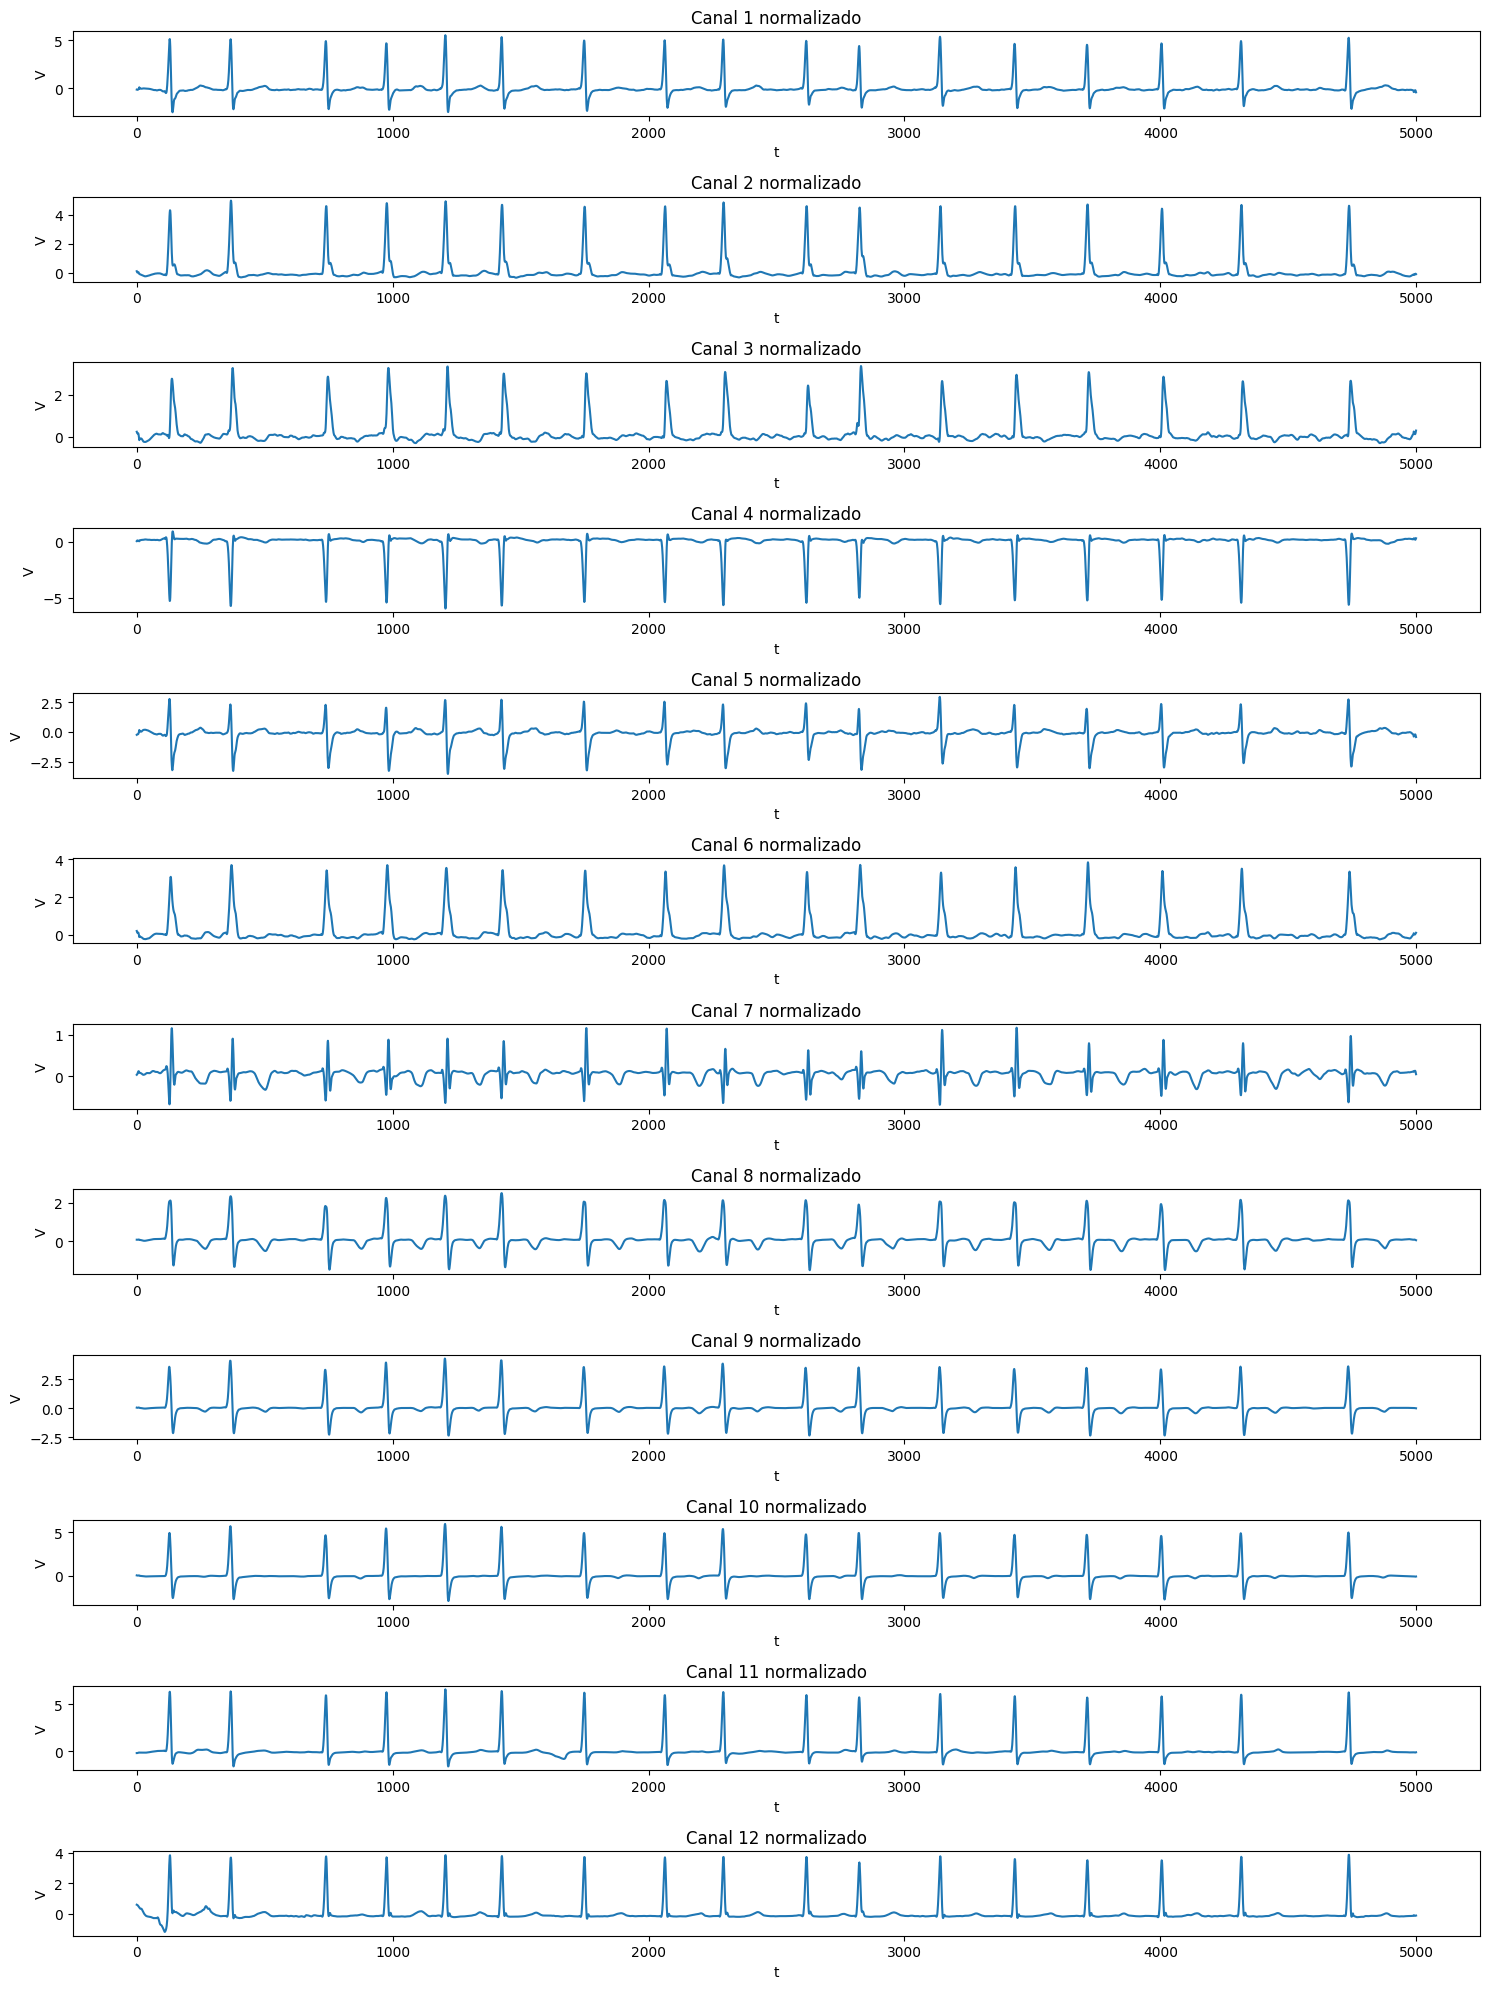

[1. 0.]


In [ ]:
# Observamos como los electrocardiogramas no cambian en su forma con las normalizaciones

fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(15, 20))
ind = 0
x1=np.array(train_df[ind].T)
# Iterar sobre cada subgráfico y trazar los datos
for i in range(12):
    axs[i].plot(x1[i])
    axs[i].set_title(f'Canal {i+1} normalizado')
    axs[i].set_xlabel('t')
    axs[i].set_ylabel('V')

# Ajustar el diseño de los subgráficos para evitar solapamiento
plt.tight_layout()
plt.show()
print(y_train[ind])

In [ ]:
#Elegimos las epocas, el tamaño de los grupos (Batch) y luego entrenamos
BATCH = 50
EPOCHS = 300
model = get_model()
#Entrenar con el método fit creando un objeto llamado "history" nos permite guardar el historial de entrenamiento a traves de las epocas
history = model.fit(train_df, y_train, epochs=EPOCHS, batch_size=BATCH, validation_data=(val_df, y_val))

Epoch 1/300
9/9 [==============================] - 3s 127ms/step - loss: 0.6979 - precision_7: 0.5081 - recall_7: 0.5069 - categorical_accuracy: 0.5093 - val_loss: 0.6892 - val_precision_7: 0.5401 - val_recall_7: 0.5401 - val_categorical_accuracy: 0.5401
Epoch 2/300
9/9 [==============================] - 0s 49ms/step - loss: 0.6705 - precision_7: 0.6181 - recall_7: 0.6181 - categorical_accuracy: 0.6181 - val_loss: 0.6845 - val_precision_7: 0.5864 - val_recall_7: 0.5864 - val_categorical_accuracy: 0.5864
Epoch 3/300
9/9 [==============================] - 0s 47ms/step - loss: 0.6708 - precision_7: 0.6181 - recall_7: 0.6181 - categorical_accuracy: 0.6181 - val_loss: 0.6796 - val_precision_7: 0.5864 - val_recall_7: 0.5864 - val_categorical_accuracy: 0.5864
Epoch 4/300
9/9 [==============================] - 0s 48ms/step - loss: 0.6493 - precision_7: 0.6343 - recall_7: 0.6343 - categorical_accuracy: 0.6343 - val_loss: 0.6780 - val_precision_7: 0.5864 - val_recall_7: 0.5864 - val_categorical_

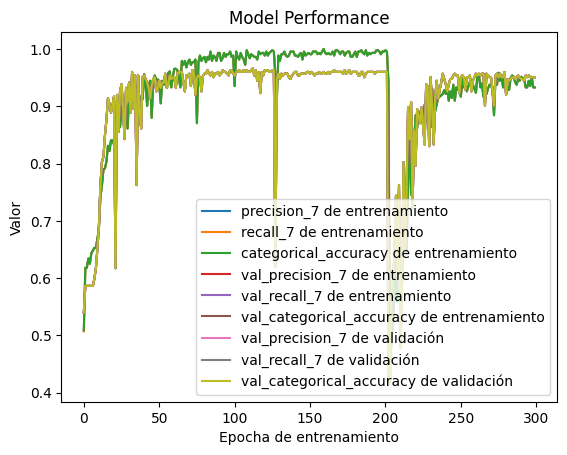

In [ ]:
historial = history.history

patron_entrenamiento = re.compile(r'(\w+(_\w+)?)$')
patron_validacion = re.compile(r'val_(\w+(_\w+)?)$')

claves_entrenamiento = [clave for clave in historial.keys() if patron_entrenamiento.match(clave) and 'loss' not in clave]
claves_validacion = [clave for clave in historial.keys() if patron_validacion.match(clave) and 'loss' not in clave]

for clave in claves_entrenamiento:
    plt.plot(historial[clave], label=f'{clave} de entrenamiento')

for clave in claves_validacion:
    plt.plot(historial[clave], label=f'{clave} de validación')

plt.xlabel('Epocha de entrenamiento')
plt.ylabel('Valor')
plt.title('Model Performance')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_df,y_test)

11/11 [==============================] - 0s 13ms/step - loss: 0.3501 - precision_7: 0.9538 - recall_7: 0.9538 - categorical_accuracy: 0.9538


[0.3501432538032532,
 0.9538461565971375,
 0.9538461565971375,
 0.9538461565971375]

In [ ]:
predicciones = model.predict(test_df)

11/11 [==============================] - 0s 8ms/step


In [ ]:
class_pred = [np.argmax(v) for v in predicciones]
y_test_ = list(clases.loc[X_test.index]["Class"])
coincidencias = [valor1 == valor2 for valor1, valor2 in zip(y_test_, class_pred)]

print(f"Predichos correctamente: {coincidencias.count(True)}")

print(f"Total de muestras: {len(y_test_)}")

print(f"Categorical accuracy: {coincidencias.count(True)/len(y_test_)}" )

Predichos correctamente: 310
Total de muestras: 325
Categorical accuracy: 0.9538461538461539


Una de las cosas más beneficiosas de TensorFlow es la portabilidad de sus modelos. Tienen inclusive una librería particular llamada TFlite para el uso de sus modelos en dispositivos móviles.

Ahora vamos a guardar los pesos y les queda de tarea hacer un nuevo código donde, en vez de entrenar, carguen los pesos recién obtenidos y luego predigan.


In [ ]:
model.save_weights(ruta_datos + "pesos/mis_pesos.h5") #h5 es un formato de keras para almacenar pesos